**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ matplotlib 3.0.2
+ pandas 0.23.4


# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [3]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк

df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [174]:
df.season.unique()

array([1, 2, 3, 4], dtype=int64)

Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

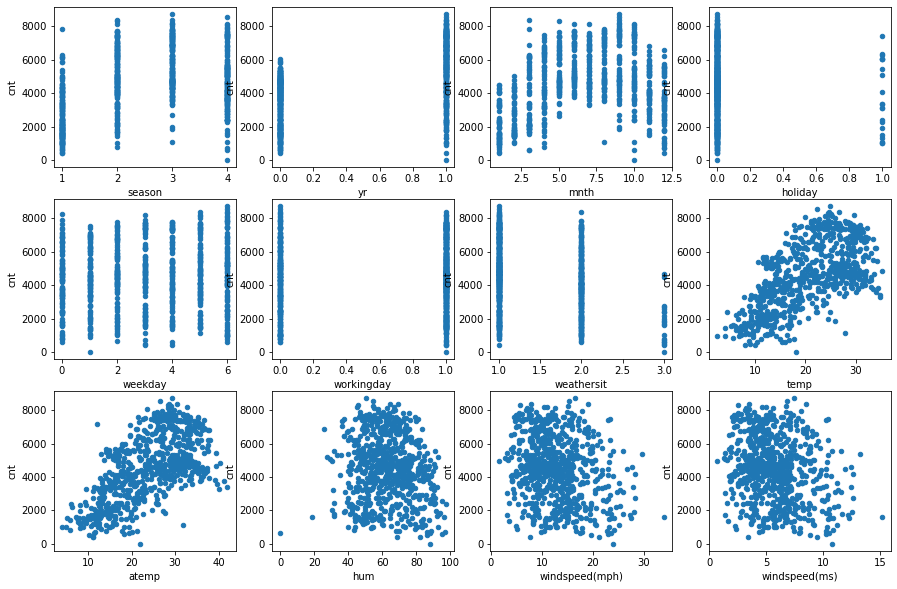

In [172]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])
    
    

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ:
   В теплые месяцы года (с апреля по сентябрь) количество арендованных велосипедов в большей степени концентрируется вокруг высоких отметок показателя, в то время как в холодные месяцы года точки находятся на более низком уровне целевого показателя.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: Температура воздуха, возможно год.

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [15]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

df.iloc[:, :-1].corrwith(df.iloc[:, -1]).sort_values(key=lambda x: abs(x))


workingday        0.061156
weekday           0.067443
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
mnth              0.279977
weathersit       -0.297391
season            0.406100
yr                0.566710
temp              0.627494
atemp             0.631066
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [22]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:

cmap = sns.color_palette('vlag', as_cmap=True)
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr().style.background_gradient(cmap=cmap)


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [23]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков

df.iloc[:, :-1].mean()


season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [30]:
from sklearn.preprocessing import scale, StandardScaler
from sklearn.utils import shuffle

In [25]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [40]:
from sklearn.linear_model import LinearRegression

In [44]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
for feature, coef in zip(df.columns[:-1], linear_regressor.coef_): 
    print(feature, coef)

season 570.8669705952359
yr 1021.9639193563858
mnth -141.30161186662224
holiday -86.760431877055
weekday 137.2262481763967
workingday 56.39162259686522
weathersit -330.23184351625554
temp 367.4614249114307
atemp 585.5691735578079
hum -145.61043001494383
windspeed(mph) 12457576985764.564
windspeed(ms) -12457576985963.018


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [46]:
from sklearn.linear_model import Lasso, Ridge

In [48]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса
lasso_reg = Lasso()
lasso_reg.fit(X, y)
for feature, coef in zip(df.columns[:-1], lasso_reg.coef_): 
    print(feature, coef)


season 560.2416160308867
yr 1019.4634940657195
mnth -128.73062703678738
holiday -86.15278133371125
weekday 137.34789390496329
workingday 55.212370641356586
weathersit -332.3698569623487
temp 376.3632362096977
atemp 576.5307935045521
hum -144.1291550034861
windspeed(mph) -197.1396894024865
windspeed(ms) -2.8049174615126408e-08


In [49]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса

ridge_reg = Ridge()
ridge_reg.fit(X, y)
for feature, coef in zip(df.columns[:-1], ridge_reg.coef_): 
    print(feature, coef)

season 563.0645722520123
yr 1018.9483787875288
mnth -131.87332028247235
holiday -86.74609799709248
weekday 138.00511117871906
workingday 55.90311037506458
weathersit -332.34978849907293
temp 386.4578891919271
atemp 566.3470470600492
hum -145.0713272986726
windspeed(mph) -99.25944108184078
windspeed(ms) -99.25944115429242


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [64]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

for i, coef in enumerate(alphas): 
    lasso_reg = Lasso(alpha=coef)
    lasso_reg.fit(X, y)
    coefs_lasso[i] = lasso_reg.coef_
    
for i, coef in enumerate(alphas): 
    ridge_reg = Ridge(alpha=coef)
    ridge_reg.fit(X, y)
    coefs_ridge[i] = ridge_reg.coef_
    


In [75]:
pd.DataFrame(data=coefs_lasso.round(3), columns=df.columns[:-1], index=alphas)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
1,560.242,1019.463,-128.731,-86.153,137.348,55.212,-332.370,376.363,576.531,-144.129,-197.140,-0.0
51,410.970,977.019,-0.000,-53.449,91.943,17.537,-318.126,322.830,610.032,-91.069,-145.066,-0.0
101,370.077,935.945,0.000,-12.162,48.889,0.000,-308.806,269.417,632.503,-27.504,-93.775,-0.0
151,332.836,891.870,0.000,-0.000,0.000,0.000,-279.617,211.052,662.921,-0.000,-50.155,-0.0
201,298.134,845.653,0.000,-0.000,0.000,0.000,-235.571,124.145,725.379,-0.000,-12.646,-0.0
251,258.927,799.237,0.000,-0.000,0.000,0.000,-190.822,72.076,750.363,-0.000,-0.000,-0.0
301,217.428,752.721,0.000,-0.000,0.000,0.000,-145.713,37.715,756.297,-0.000,-0.000,-0.0
351,175.930,706.204,0.000,-0.000,0.000,0.000,-100.605,3.661,761.926,-0.000,-0.000,-0.0
401,134.628,659.633,0.000,-0.000,0.000,0.000,-55.511,0.000,737.348,-0.000,-0.000,-0.0
451,93.352,613.055,0.000,-0.000,0.000,0.000,-10.419,0.000,709.131,-0.000,-0.000,-0.0


In [76]:
pd.DataFrame(data=coefs_ridge.round(3), columns=df.columns[:-1], index=alphas)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
1,563.065,1018.948,-131.873,-86.746,138.005,55.903,-332.350,386.458,566.347,-145.071,-99.259,-99.259
51,461.179,954.308,-41.565,-84.913,126.604,54.252,-313.275,458.901,481.444,-151.291,-101.627,-101.627
101,403.977,898.084,5.674,-81.911,117.941,52.728,-298.409,455.290,467.431,-152.686,-102.102,-102.102
151,366.604,848.463,34.027,-78.772,110.680,51.257,-286.125,447.480,455.754,-151.483,-102.005,-102.005
201,339.745,804.251,52.490,-75.717,104.403,49.842,-275.486,438.510,444.764,-148.944,-101.586,-101.586
251,319.159,764.561,65.152,-72.820,98.879,48.485,-266.003,429.214,434.235,-145.698,-100.965,-100.965
301,302.636,728.709,74.138,-70.099,93.956,47.185,-257.391,419.926,424.122,-142.089,-100.209,-100.209
351,288.913,696.146,80.660,-67.555,89.529,45.943,-249.471,410.800,414.409,-138.317,-99.361,-99.361
401,277.213,666.430,85.459,-65.179,85.519,44.757,-242.124,401.912,405.086,-134.499,-98.449,-98.449
451,267.031,639.195,89.012,-62.959,81.865,43.625,-235.264,393.298,396.138,-130.710,-97.493,-97.493


Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

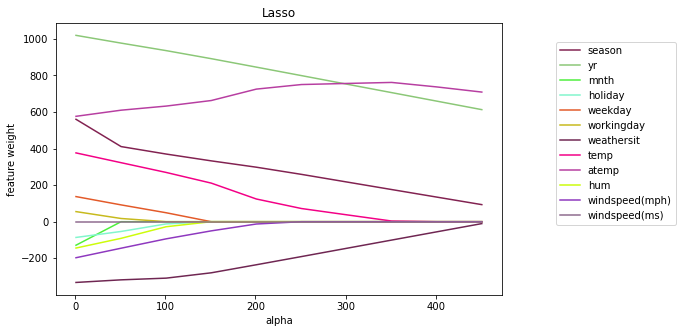

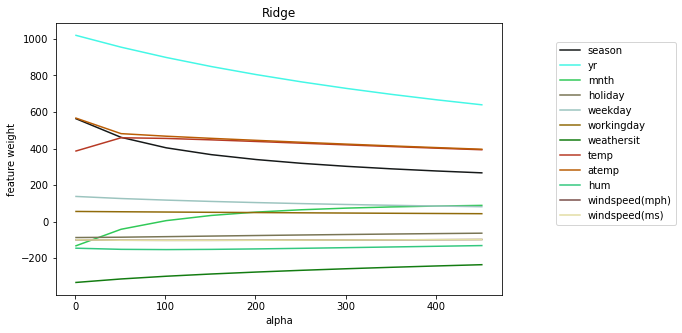

In [69]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")
# plt.ylim(-0.001, 0.001)

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: 
    It is worth noting that when λ is very large, most of the cost will be coming from the regularization term λ * sum (θ²) and not the actual cost sum((h_θ - y)²), hence in that case it's mostly about minimizing the regularization term λ * sum (θ²) by tending θ towards 0 (θ → 0)
    
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ:   Lasso - да, но только при не очень больших $\lambda$
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso (L1)

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [128]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

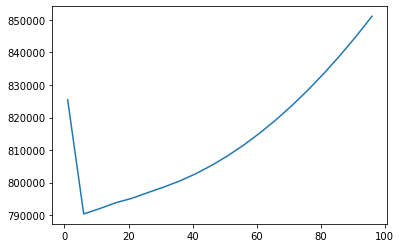

In [145]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
lasso_cv = LassoCV(alphas=alphas, cv=3).fit(X, y)
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1))

In [146]:
lasso_cv.alpha_

6

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

In [148]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_


for i in range(3): 
    print(lasso_cv.alphas_[lasso_cv.mse_path_[:, i].argmin()])

41
6
1


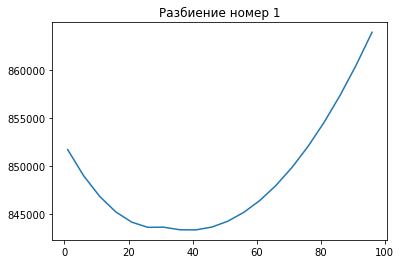

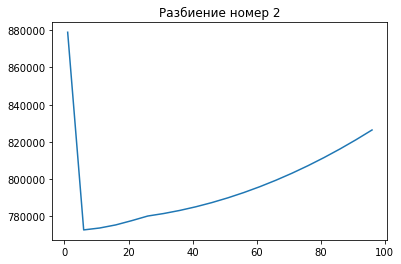

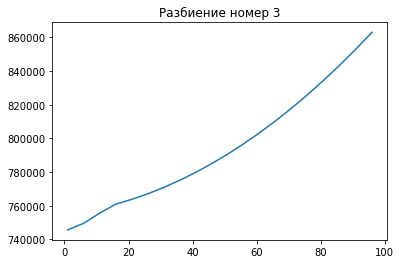

In [150]:
for i in range(3): 
    plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_[:, i])
    plt.title(f"Разбиение номер {i + 1}")
    plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

In [180]:
my_dict = {feature: coef for feature, coef in zip(df.columns[:-1], lasso_cv.coef_)}
my_dict = {feature: coef for feature, coef in sorted(my_dict.items(), reverse=True, key=lambda x: x[1], )}

print(list(my_dict.items())[:5]) 
print(list(my_dict.items())[-3:])

[('yr', 1015.0602226430595), ('atemp', 581.3969310654954), ('season', 532.0189828413535), ('temp', 370.6798550300367), ('weekday', 132.50446549095793)]
[('hum', -140.0074055006889), ('windspeed(mph)', -191.77140847135027), ('weathersit', -330.55985673998117)]


In [190]:
{feature: coef for feature, coef in my_dict.items() if abs(coef) <= 1e-3}

{'windspeed(ms)': -2.6855024557067635e-08}

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: year, atemp, season, temp, weekday. Наиболее линейная связь была заметна для признаков temp и atemp. Для них можно определенно сказать, что чем больше значение этих признаков, тем больше количество арендованных велосипедов. Для показателя year связь также положительная и линейная, однако делать определенный вывод по данным за 2 года не очень надежно. Для показателя season связь скорее носит сезонный характер (синусоида), в пределах года имеет вид $-x^2$.
    Для показателя weekday линейность связи не четко выражена
1. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: На графике зависимостей целевой переменной от показателей hum и windspeed(mph) действительно можно усмотреть обратную корреляцию, однако также присутствует большое количество шума (большие отклонения от тренда). Для данных показателей логично утверждать, что чем больше скорость ветра и уровень влажности на улице, тем меньше велосипедов будет арендовано, посколько усиление ветра и повышение уровня влажности, очевидно, указывают на неблагоприятную погоду. Данная зависимость также выражается посредством влияния на целевую переменную показателя weathersit, который по сути отражает то же самое.
1. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: windspeed(ms). На графике зависимость схожа с графиком для windspeed(mph), однако, как было показано ранее, между показателями windspeed(mph), windspeed(ms) существует линейная зависимость, по сути, они характеризуют одно и то же явление. Поэтому L1 регуляризатор занулил коэффициент при данном признаке как избыточный в модели.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.